In [81]:
#General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from collections import defaultdict
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity


# Specific neural network models & layer types
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow import keras



In [14]:
#our folder path is the following:
main_folder = r'Pandora_V1'
img_height = 64
img_width = 64

In [29]:
images_array = []
KM_features = []
image_id =  []

for folder in os.listdir(main_folder):
    for file in os.listdir(os.path.join(main_folder, folder)):
                
        path = os.path.join(main_folder, folder, file)
        img = cv2.imread(path,1) #select all the images in the folder
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #transform into RGB format
        img = cv2.resize(img, (img_width,img_height), interpolation = cv2.INTER_CUBIC) #rewsize each image 
        img = np.array(img).astype('uint8') # change data type to float

        # we append the image into the images_array.
        images_array.append(img)
        
        # We also want to keep track of each individual image with an id
        image_id.append(path)

In [30]:
#Checking the shape of the array
images_array = np.array(images_array)
print(f'the images_array has a shape of: {images_array.shape}')

the images_array has a shape of: (7694, 64, 64, 3)


In [153]:
# Let us define some paramenters
epochs = 50
channels =3
num_classes = 5

In [192]:
# building the encoder. 
encoder_model=Sequential()

encoder_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (64, 64, 3), padding='same'))
encoder_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', padding='same'))

encoder_model.add(MaxPooling2D(pool_size=(2, 2)))
encoder_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.add(MaxPooling2D(pool_size=(2, 2)))
encoder_model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2D(128, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.add(MaxPooling2D(pool_size=(2, 2)))
encoder_model.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2D(256, kernel_size=(3, 3), activation = 'relu',padding='same'))

# build the decoder.
encoder_model.add(Conv2DTranspose(256, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2DTranspose(256, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.add(UpSampling2D((2,2)))
encoder_model.add(Conv2DTranspose(128, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2DTranspose(128, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.add(UpSampling2D((2,2)))
encoder_model.add(Conv2DTranspose(64, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2DTranspose(64, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.add(UpSampling2D((2,2)))
encoder_model.add(Conv2DTranspose(32, kernel_size=(3, 3), activation = 'relu',padding='same'))
encoder_model.add(Conv2DTranspose(32, kernel_size=(3, 3), activation = 'relu',padding='same'))


In [193]:
# Declare the output layer

encoder_model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation = 'relu',padding='same'))

encoder_model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # Metric used to evaluate model
    metrics=keras.metrics.MeanSquaredError()
)

# summary
encoder_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_247 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 16, 16, 128)     

In [194]:
%%time
# Train our model for 10 epochs, use y for both the input and output.
history = encoder_model.fit(images_array, images_array,epochs=500, validation_split=0.1, verbose=1)

Epoch 1/500
217/217 [==============================] - 212s 979ms/step - loss: 4570.3179 - mean_squared_error: 4570.3179 - val_loss: 1525.5653 - val_mean_squared_error: 1525.5653
Epoch 2/500
217/217 [==============================] - 210s 966ms/step - loss: 1712.6825 - mean_squared_error: 1712.6825 - val_loss: 1794.7216 - val_mean_squared_error: 1794.7216
Epoch 3/500
217/217 [==============================] - 209s 963ms/step - loss: 1625.1079 - mean_squared_error: 1625.1079 - val_loss: 1111.3729 - val_mean_squared_error: 1111.3729
Epoch 4/500
217/217 [==============================] - 207s 952ms/step - loss: 1280.5861 - mean_squared_error: 1280.5861 - val_loss: 1099.6710 - val_mean_squared_error: 1099.6710
Epoch 5/500
217/217 [==============================] - 207s 953ms/step - loss: 1781.1055 - mean_squared_error: 1781.1055 - val_loss: 1248.2603 - val_mean_squared_error: 1248.2603
Epoch 6/500
217/217 [==============================] - 207s 955ms/step - loss: 1255.0663 - mean_squared_e

Epoch 47/500
217/217 [==============================] - 208s 958ms/step - loss: 972.2980 - mean_squared_error: 972.2980 - val_loss: 752.6000 - val_mean_squared_error: 752.6000
Epoch 48/500
217/217 [==============================] - 206s 949ms/step - loss: 951.8662 - mean_squared_error: 951.8662 - val_loss: 753.0664 - val_mean_squared_error: 753.0664
Epoch 49/500
217/217 [==============================] - 207s 952ms/step - loss: 957.9818 - mean_squared_error: 957.9818 - val_loss: 795.8031 - val_mean_squared_error: 795.8031
Epoch 50/500
217/217 [==============================] - 208s 960ms/step - loss: 942.6339 - mean_squared_error: 942.6339 - val_loss: 752.3680 - val_mean_squared_error: 752.3680
Epoch 51/500
217/217 [==============================] - 207s 953ms/step - loss: 946.2339 - mean_squared_error: 946.2339 - val_loss: 716.0256 - val_mean_squared_error: 716.0256
Epoch 52/500
217/217 [==============================] - 206s 949ms/step - loss: 960.6890 - mean_squared_error: 960.6890 

217/217 [==============================] - 210s 969ms/step - loss: 761.7556 - mean_squared_error: 761.7556 - val_loss: 646.1452 - val_mean_squared_error: 646.1452
Epoch 94/500
217/217 [==============================] - 208s 961ms/step - loss: 753.1363 - mean_squared_error: 753.1363 - val_loss: 563.9956 - val_mean_squared_error: 563.9956
Epoch 95/500
217/217 [==============================] - 207s 952ms/step - loss: 763.8641 - mean_squared_error: 763.8641 - val_loss: 573.6280 - val_mean_squared_error: 573.6280
Epoch 96/500
217/217 [==============================] - 208s 957ms/step - loss: 749.7783 - mean_squared_error: 749.7783 - val_loss: 571.2966 - val_mean_squared_error: 571.2966
Epoch 97/500
217/217 [==============================] - 208s 956ms/step - loss: 761.4037 - mean_squared_error: 761.4037 - val_loss: 556.4970 - val_mean_squared_error: 556.4970
Epoch 98/500
217/217 [==============================] - 209s 962ms/step - loss: 741.9523 - mean_squared_error: 741.9523 - val_loss: 5

217/217 [==============================] - 209s 965ms/step - loss: 680.7972 - mean_squared_error: 680.7972 - val_loss: 516.6395 - val_mean_squared_error: 516.6395
Epoch 140/500
217/217 [==============================] - 210s 966ms/step - loss: 684.5456 - mean_squared_error: 684.5456 - val_loss: 513.6718 - val_mean_squared_error: 513.6718
Epoch 141/500
217/217 [==============================] - 209s 962ms/step - loss: 678.8332 - mean_squared_error: 678.8332 - val_loss: 511.3704 - val_mean_squared_error: 511.3704
Epoch 142/500
217/217 [==============================] - 208s 959ms/step - loss: 673.5305 - mean_squared_error: 673.5305 - val_loss: 528.3499 - val_mean_squared_error: 528.3499
Epoch 143/500
217/217 [==============================] - 208s 961ms/step - loss: 684.1656 - mean_squared_error: 684.1656 - val_loss: 542.2707 - val_mean_squared_error: 542.2707
Epoch 144/500
217/217 [==============================] - 209s 962ms/step - loss: 667.0910 - mean_squared_error: 667.0910 - val_lo

217/217 [==============================] - 213s 979ms/step - loss: 646.4084 - mean_squared_error: 646.4084 - val_loss: 487.3044 - val_mean_squared_error: 487.3044
Epoch 186/500
217/217 [==============================] - 212s 978ms/step - loss: 644.5008 - mean_squared_error: 644.5008 - val_loss: 484.4888 - val_mean_squared_error: 484.4888
Epoch 187/500
217/217 [==============================] - 214s 986ms/step - loss: 644.2188 - mean_squared_error: 644.2188 - val_loss: 510.5088 - val_mean_squared_error: 510.5088
Epoch 188/500
217/217 [==============================] - 213s 981ms/step - loss: 638.5043 - mean_squared_error: 638.5043 - val_loss: 490.0166 - val_mean_squared_error: 490.0166
Epoch 189/500
217/217 [==============================] - 209s 961ms/step - loss: 669.9413 - mean_squared_error: 669.9413 - val_loss: 768.2650 - val_mean_squared_error: 768.2650
Epoch 190/500
217/217 [==============================] - 210s 967ms/step - loss: 668.8793 - mean_squared_error: 668.8793 - val_lo

217/217 [==============================] - 216s 997ms/step - loss: 617.7187 - mean_squared_error: 617.7187 - val_loss: 550.5079 - val_mean_squared_error: 550.5079
Epoch 232/500
217/217 [==============================] - 214s 985ms/step - loss: 624.9018 - mean_squared_error: 624.9018 - val_loss: 470.1576 - val_mean_squared_error: 470.1576
Epoch 233/500
217/217 [==============================] - 210s 968ms/step - loss: 625.4653 - mean_squared_error: 625.4653 - val_loss: 479.3549 - val_mean_squared_error: 479.3549
Epoch 234/500
217/217 [==============================] - 210s 967ms/step - loss: 632.4944 - mean_squared_error: 632.4944 - val_loss: 480.2371 - val_mean_squared_error: 480.2371
Epoch 235/500
217/217 [==============================] - 211s 974ms/step - loss: 615.0327 - mean_squared_error: 615.0327 - val_loss: 477.9525 - val_mean_squared_error: 477.9525
Epoch 236/500
217/217 [==============================] - 210s 969ms/step - loss: 675.9783 - mean_squared_error: 675.9783 - val_lo

217/217 [==============================] - 222s 1s/step - loss: 607.8000 - mean_squared_error: 607.8000 - val_loss: 472.2781 - val_mean_squared_error: 472.2781
Epoch 278/500
217/217 [==============================] - 222s 1s/step - loss: 599.8885 - mean_squared_error: 599.8885 - val_loss: 470.2676 - val_mean_squared_error: 470.2676
Epoch 279/500
217/217 [==============================] - 217s 1s/step - loss: 607.0502 - mean_squared_error: 607.0502 - val_loss: 462.9798 - val_mean_squared_error: 462.9798
Epoch 280/500
217/217 [==============================] - 213s 980ms/step - loss: 600.6082 - mean_squared_error: 600.6082 - val_loss: 467.3779 - val_mean_squared_error: 467.3779
Epoch 281/500
217/217 [==============================] - 213s 981ms/step - loss: 608.7164 - mean_squared_error: 608.7164 - val_loss: 461.7299 - val_mean_squared_error: 461.7299
Epoch 282/500
217/217 [==============================] - 219s 1s/step - loss: 613.2606 - mean_squared_error: 613.2606 - val_loss: 481.2368

217/217 [==============================] - 215s 989ms/step - loss: 595.0051 - mean_squared_error: 595.0051 - val_loss: 455.5515 - val_mean_squared_error: 455.5515
Epoch 325/500
217/217 [==============================] - 214s 988ms/step - loss: 594.8960 - mean_squared_error: 594.8960 - val_loss: 462.0065 - val_mean_squared_error: 462.0065
Epoch 326/500
217/217 [==============================] - 212s 979ms/step - loss: 604.2004 - mean_squared_error: 604.2004 - val_loss: 469.8966 - val_mean_squared_error: 469.8966
Epoch 327/500
217/217 [==============================] - 216s 994ms/step - loss: 595.6723 - mean_squared_error: 595.6723 - val_loss: 457.3605 - val_mean_squared_error: 457.3605
Epoch 328/500
217/217 [==============================] - 214s 985ms/step - loss: 592.1423 - mean_squared_error: 592.1423 - val_loss: 487.3003 - val_mean_squared_error: 487.3003
Epoch 329/500
217/217 [==============================] - 213s 982ms/step - loss: 621.2931 - mean_squared_error: 621.2931 - val_lo

217/217 [==============================] - 214s 985ms/step - loss: 589.9641 - mean_squared_error: 589.9641 - val_loss: 456.2539 - val_mean_squared_error: 456.2539
Epoch 371/500
217/217 [==============================] - 210s 968ms/step - loss: 598.3467 - mean_squared_error: 598.3467 - val_loss: 455.6544 - val_mean_squared_error: 455.6544
Epoch 372/500
217/217 [==============================] - 211s 971ms/step - loss: 586.0910 - mean_squared_error: 586.0910 - val_loss: 462.9639 - val_mean_squared_error: 462.9639
Epoch 373/500
217/217 [==============================] - 211s 971ms/step - loss: 586.2386 - mean_squared_error: 586.2386 - val_loss: 451.5947 - val_mean_squared_error: 451.5947
Epoch 374/500
217/217 [==============================] - 209s 965ms/step - loss: 592.9324 - mean_squared_error: 592.9324 - val_loss: 463.8066 - val_mean_squared_error: 463.8066
Epoch 375/500
217/217 [==============================] - 213s 980ms/step - loss: 586.1852 - mean_squared_error: 586.1852 - val_lo

217/217 [==============================] - 212s 976ms/step - loss: 589.7812 - mean_squared_error: 589.7812 - val_loss: 451.3303 - val_mean_squared_error: 451.3303
Epoch 417/500
217/217 [==============================] - 211s 974ms/step - loss: 584.2756 - mean_squared_error: 584.2756 - val_loss: 468.2469 - val_mean_squared_error: 468.2469
Epoch 418/500
217/217 [==============================] - 210s 968ms/step - loss: 597.0429 - mean_squared_error: 597.0429 - val_loss: 456.8210 - val_mean_squared_error: 456.8210
Epoch 419/500
217/217 [==============================] - 212s 976ms/step - loss: 580.3749 - mean_squared_error: 580.3749 - val_loss: 449.6488 - val_mean_squared_error: 449.6488
Epoch 420/500
217/217 [==============================] - 211s 974ms/step - loss: 579.5942 - mean_squared_error: 579.5942 - val_loss: 456.6031 - val_mean_squared_error: 456.6031
Epoch 421/500
217/217 [==============================] - 211s 971ms/step - loss: 581.8641 - mean_squared_error: 581.8641 - val_lo

217/217 [==============================] - 215s 991ms/step - loss: 580.3893 - mean_squared_error: 580.3893 - val_loss: 477.7690 - val_mean_squared_error: 477.7690
Epoch 463/500
217/217 [==============================] - 214s 988ms/step - loss: 584.2235 - mean_squared_error: 584.2235 - val_loss: 452.2433 - val_mean_squared_error: 452.2433
Epoch 464/500
217/217 [==============================] - 214s 986ms/step - loss: 576.8943 - mean_squared_error: 576.8943 - val_loss: 450.1205 - val_mean_squared_error: 450.1205
Epoch 465/500
217/217 [==============================] - 213s 983ms/step - loss: 583.2014 - mean_squared_error: 583.2014 - val_loss: 448.1604 - val_mean_squared_error: 448.1604
Epoch 466/500
217/217 [==============================] - 215s 989ms/step - loss: 582.3356 - mean_squared_error: 582.3356 - val_loss: 444.8303 - val_mean_squared_error: 444.8303
Epoch 467/500
217/217 [==============================] - 215s 991ms/step - loss: 575.2164 - mean_squared_error: 575.2164 - val_lo

In [195]:
decoded = encoder_model.predict(images_array)

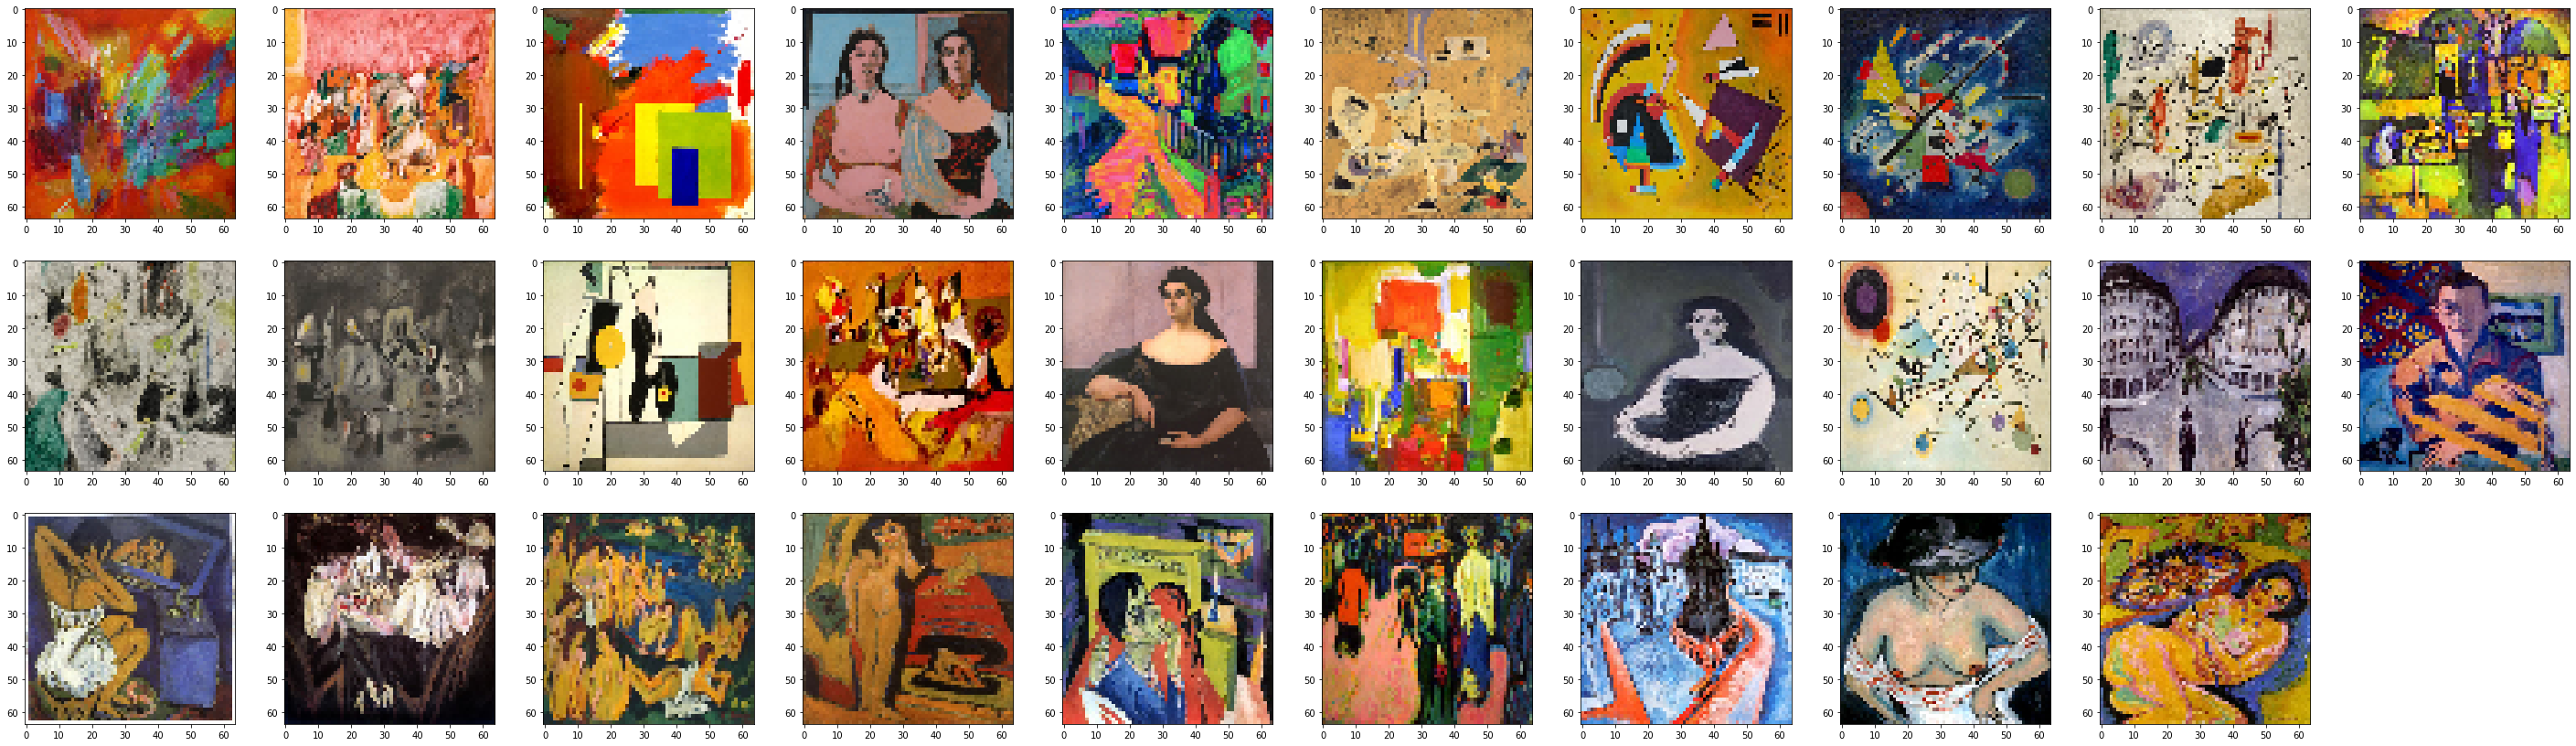

In [196]:
#using the dictionary that we created before we plot each painting as a tile and subplot to see the final result

fig=plt.figure(figsize = (50,50))

for i in range(1,30):
    img = decoded[i,:,:,:].astype('uint8')
    img2=images_array[i,:,:,:]
    fig.add_subplot(10,10,i)
    plt.imshow(img2)
plt.show()

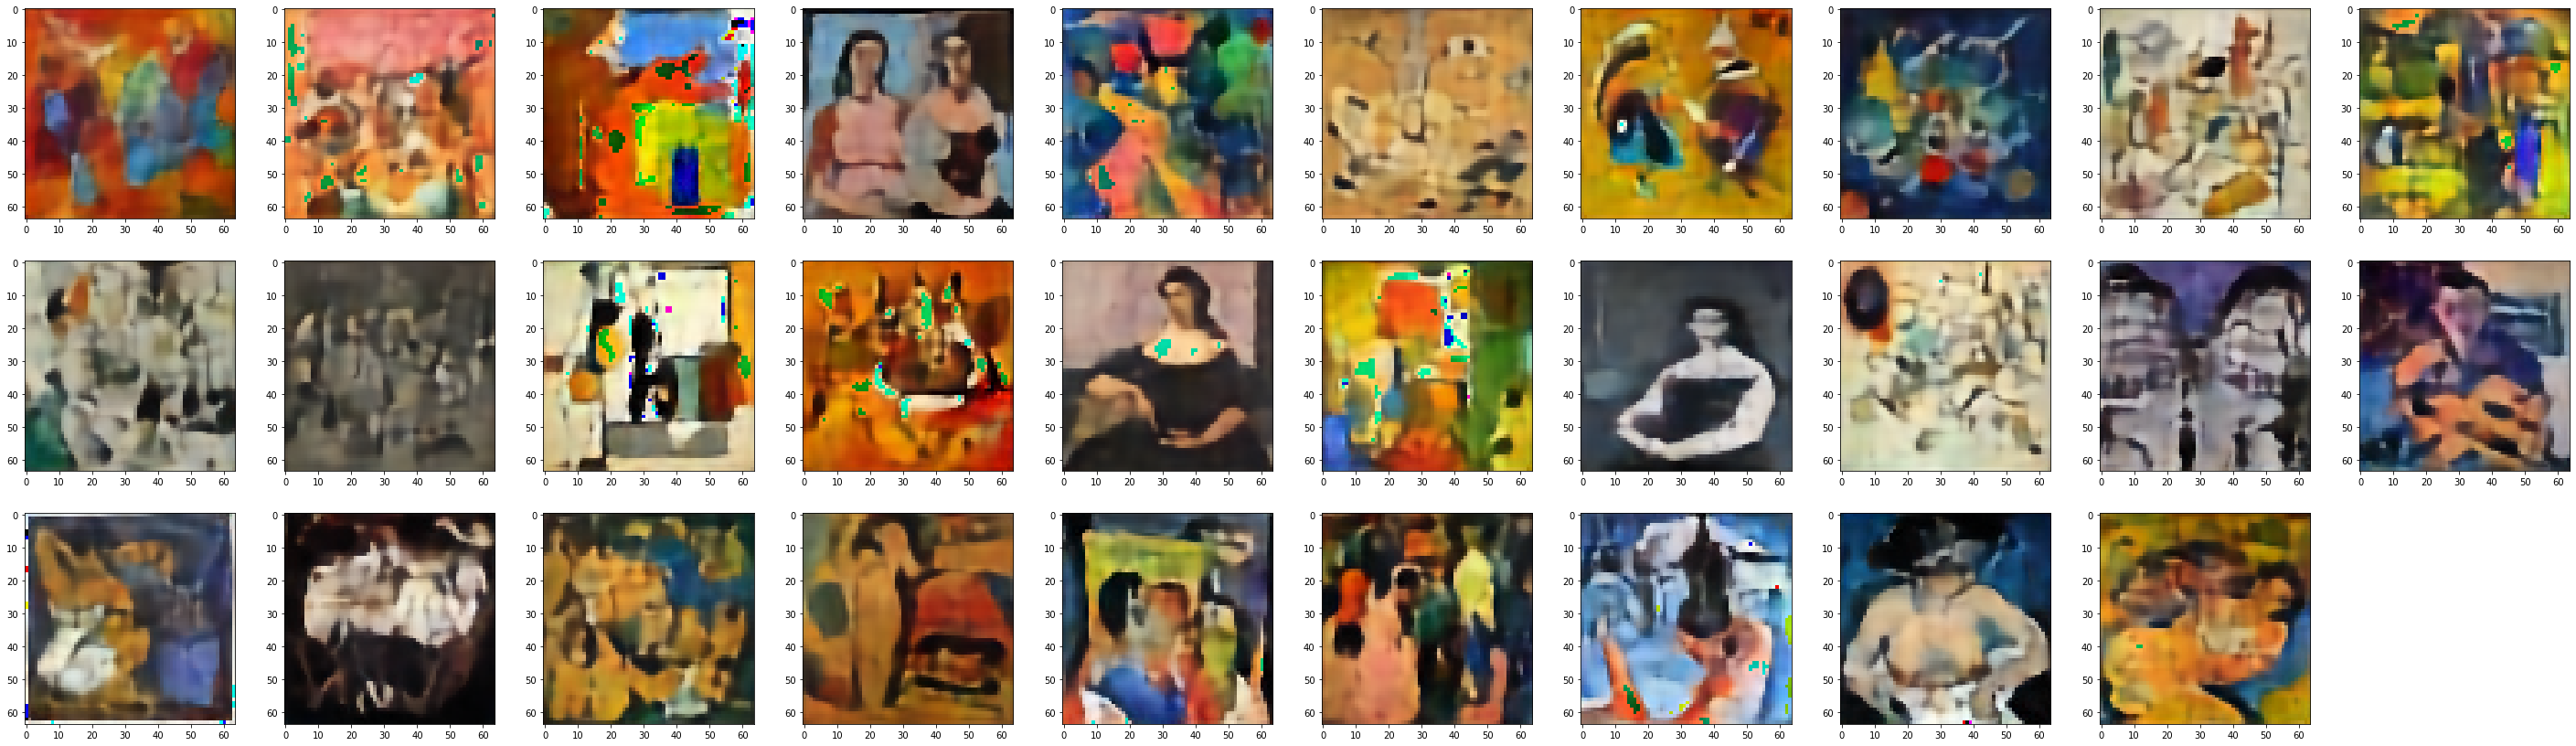

In [197]:
#using the dictionary that we created before we plot each painting as a tile and subplot to see the final result

fig=plt.figure(figsize = (50,50))

for i in range(1,30):
    img = decoded[i,:,:,:].astype('uint8')
    img2=images_array[i,:,:,:]
    fig.add_subplot(10,10,i)
    plt.imshow(img)
plt.show()

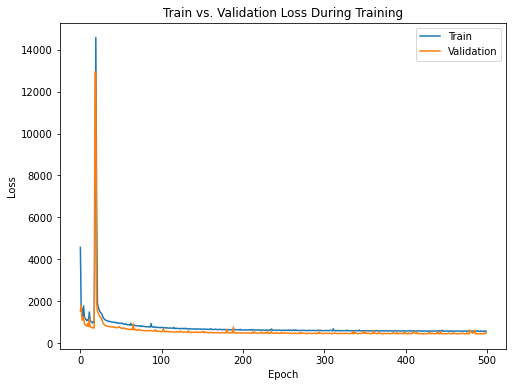

In [198]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss During Training")
plt.legend(["Train", "Validation"])
plt.show()

In [215]:
model = Sequential()
model.add(encoder_model.layers[0])
model.add(encoder_model.layers[1])
model.add(encoder_model.layers[2])
model.add(encoder_model.layers[3])
model.add(encoder_model.layers[4])
model.add(encoder_model.layers[5])
model.add(encoder_model.layers[6])
model.add(encoder_model.layers[7])
model.add(encoder_model.layers[8])
model.add(encoder_model.layers[9])
model.add(encoder_model.layers[10])
model.add(Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_247 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 16, 16, 128)     

In [216]:
for i in range(0,11):
    model.layers[i] = False
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_247 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 16, 16, 128)     

In [217]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.MeanSquaredError(),
    # Metric used to evaluate model
    metrics=keras.metrics.MeanSquaredError()
)
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_247 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_248 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_249 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_250 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 16, 16, 128)     

In [218]:
class_0 = model.predict(images_array)

In [219]:
class_0.shape

(7694, 5)

In [221]:
class_0[1]

array([7.9111487e-08, 9.9431866e-01, 1.5988572e-08, 5.6810332e-03,
       2.4336839e-07], dtype=float32)

In [227]:
predicted_classes = np.argmax(class_0,axis=1)

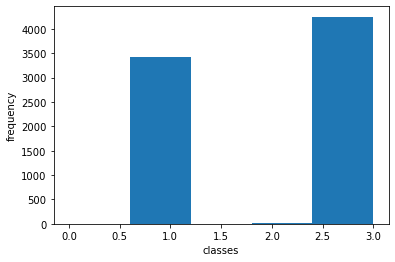

In [228]:
plt.figure()
plt.hist(predicted_classes, bins=5)
plt.ylabel('frequency')
plt.xlabel('classes')
plt.show()

3